<a href="https://colab.research.google.com/github/rushikeshnaik779/tfcerti/blob/main/transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi


Thu Aug 19 15:41:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-08-19 15:41:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   228MB/s    in 0.7s    

2021-08-19 15:41:49 (228 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os 

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories & {len(filenames)} image in '{dirpath}'.")

There are 2 directories & 0 image in '10_food_classes_10_percent'.
There are 10 directories & 0 image in '10_food_classes_10_percent/test'.
There are 0 directories & 250 image in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories & 250 image in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories & 250 image in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories & 250 image in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories & 250 image in '10_food_classes_10_percent/test/sushi'.
There are 0 directories & 250 image in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories & 250 image in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories & 250 image in '10_food_classes_10_percent/test/pizza'.
There are 0 directories & 250 image in '10_food_classes_10_percent/test/steak'.
There are 0 directories & 250 image in '10_food_classes_10_percent/test/ramen'.
There are 10 directori

In [ ]:
# setup data inputs 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)


print("Training Images: ")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir, 
    target_size = IMAGE_SHAPE, 
    batch_size = BATCH_SIZE, 
    class_mode = "categorical"
)

print("Testing Images: ")
test_data = test_datagen.flow_from_directory(
    test_dir, 
    target_size = IMAGE_SHAPE, 
    batch_size = BATCH_SIZE, 
    class_mode = "categorical"
)

Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


# WHAT ARE CALLBACKS 

* TensorBoard 
* ModelCheckpointing 
* Early Stopping

In [ ]:
# Create TensorBoard Callback ( functionized because we need to create a new one for each)
import datetime 


def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/"+ experiment_name +"/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f"Saving TensorBoard log files to : {log_dir}")
    return tensorboard_callback

# Creating Model Uisng Tensorflow Hub

In [ ]:
## Let's compare the two models 

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras import layers 


In [ ]:
# let's create_model() function 

def create_model(model_url, num_classes=10):
    """
    Takes a Tensorflow hub URL and creates a keras Sequential model with it.
    

    Args : 
        model_url : (str) A tensorflow Hub features extraction URL. 
        num_classes (int) : Number of output neurons in the op layer,
        should be equal to number of target clases , default 10.

    Returns : 
    A uncompiled Keras Sequential Model with model_url as feature extractor 
    layer and Dense output layer with number classes output neurons 


    """
    # Download the pretrained model and save it as keras layer 

    feature_extractor_layer = hub.KerasLayer(
        model_url, 
        trainable=False, 
        name = "FEL", 
        input_shape = IMAGE_SHAPE+(3,)
    )

    # create out seq model 
    model = tf.keras.Sequential([
                                 feature_extractor_layer,
                                 tf.keras.layers.Dense(num_classes, activation="softmax", name="outputlayers")
    ])

    return model 


# Creatign and testing ResNet TF Hub Feature Extraction Model 

In [ ]:
# create ResNet Model 

resnet_model = create_model(
    resnet_url, 
    num_classes = train_data_10_percent.num_classes,
    

)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FEL (KerasLayer)             (None, 2048)              23564800  
_________________________________________________________________
outputlayers (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# compile resent model 

resnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
# lets fit model 
resent_history = resnet_model.fit(
    train_data_10_percent, 
    epochs=5, 
    steps_per_epoch=len(train_data_10_percent),
    validation_data = test_data,
    callbacks = [create_tensorboard_callback(
        dir_name = "tensorflow_hub", 
        experiment_name = "resnet50v2"
    )]
)



Saving TensorBoard log files to : tensorflow_hub/resnet50v2/20210819-154209
Epoch 1/5
24/24 [==============================] - 52s 787ms/step - loss: 1.9463 - accuracy: 0.3640 - val_loss: 1.2059 - val_accuracy: 0.6236
Epoch 2/5
24/24 [==============================] - 16s 678ms/step - loss: 0.8920 - accuracy: 0.7227 - val_loss: 0.8670 - val_accuracy: 0.7172
Epoch 3/5
24/24 [==============================] - 16s 676ms/step - loss: 0.6135 - accuracy: 0.8120 - val_loss: 0.7558 - val_accuracy: 0.7524
Epoch 4/5
24/24 [==============================] - 16s 675ms/step - loss: 0.4547 - accuracy: 0.8960 - val_loss: 0.7030 - val_accuracy: 0.7696
Epoch 5/5
24/24 [==============================] - 16s 675ms/step - loss: 0.3777 - accuracy: 0.9187 - val_loss: 0.6907 - val_accuracy: 0.7712


In [ ]:
# Let's create a function plot a loss curve 
# Tidbit 

import matplotlib.pyplot as plt 

def plot_loss_curves(history):
    """
    Returns seperate loss curves for training and validation metrics. 

    Args: 
        history: Tensorflow history object 

    returns : 
    plots of training/ validation loss and accuracy 

    """ 

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']


    epochs = range(len(loss))
    
    #plot loss
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss", size=22)
    plt.legend()
    plt.xlabel("Loss")
    plt.show()

    # Plot accuracy 
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Val_Accuracy")
    plt.title("Accuracy", size=22)
    plt.legend()
    plt.xlabel("Accuracy")
    plt.show()

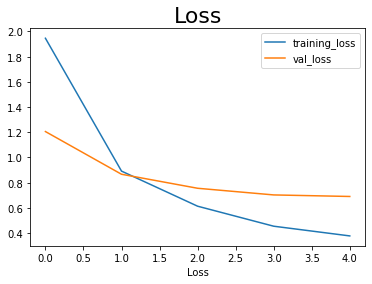

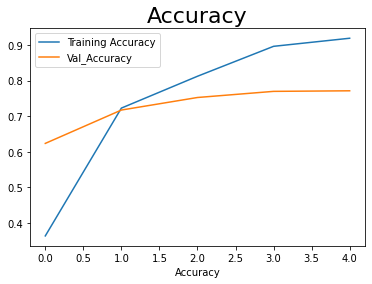

In [ ]:
plot_loss_curves(resent_history)

# Creating and testing EfficientNetB0 Tensorflow Hub Feature Extraction Model

In [ ]:
efficientNet = create_model(
   efficientnet_url, 
   num_classes = train_data_10_percent.num_classes


)

In [ ]:
efficientNet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FEL (KerasLayer)             (None, 1280)              4049564   
_________________________________________________________________
outputlayers (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientNet.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
efficientNet_history = efficientNet.fit(
    train_data_10_percent, 
    epochs=5, 
    steps_per_epoch = len(train_data_10_percent), 
    validation_data = test_data,
    callbacks = [create_tensorboard_callback(
        dir_name = "tensorflow_hub", 
        experiment_name = "effi_net50v2"
    )]

)

Saving TensorBoard log files to : tensorflow_hub/effi_net50v2/20210819-164839
Epoch 1/5
24/24 [==============================] - 24s 763ms/step - loss: 1.8896 - accuracy: 0.3973 - val_loss: 1.3306 - val_accuracy: 0.7152
Epoch 2/5
24/24 [==============================] - 15s 638ms/step - loss: 1.0913 - accuracy: 0.7533 - val_loss: 0.8808 - val_accuracy: 0.8140
Epoch 3/5
24/24 [==============================] - 15s 638ms/step - loss: 0.7746 - accuracy: 0.8333 - val_loss: 0.7052 - val_accuracy: 0.8392
Epoch 4/5
24/24 [==============================] - 15s 631ms/step - loss: 0.6183 - accuracy: 0.8680 - val_loss: 0.6144 - val_accuracy: 0.8496
Epoch 5/5
24/24 [==============================] - 15s 631ms/step - loss: 0.5235 - accuracy: 0.8907 - val_loss: 0.5614 - val_accuracy: 0.8524


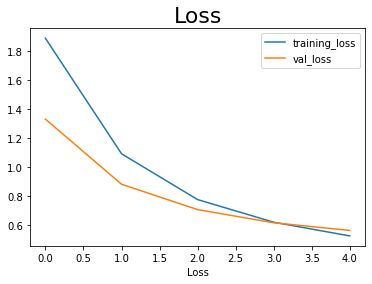

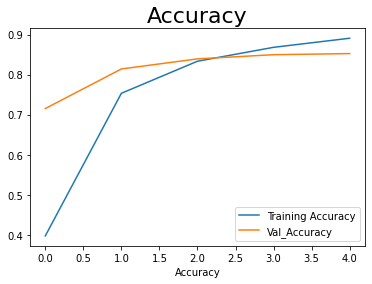

In [ ]:
plot_loss_curves(efficientNet_history)